<a href="https://colab.research.google.com/github/yiruchen1993/1st-DL-CVMarathon/blob/feature%2Fdaily_learning/Day45_facial_keypoint_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 範例
接下來的程式碼會示範如何在檢測到人臉關鍵點的情況下，做出給人臉戴上太陽眼鏡的濾鏡效果

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/study/DL_CV/'

/content/gdrive/My Drive/study/DL_CV


In [4]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
os.environ['KAGGLE_USERNAME'] = "yiruchen1993" # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
os.environ['KAGGLE_KEY'] = "d156daca72dfc25bdf525af1a54b60a8" # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip
!unzip test.zip
!unzip training.zip

SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
training.zip: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open facial-keypoints-detection.zip, facial-keypoints-detection.zip.zip or facial-keypoints-detection.zip.ZIP.
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.csv            


In [5]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [6]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [9]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=50, verbose=1)
# save the model weights
model.save_weights('weights.h5')

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 0.0084
Epoch 00001: val_loss improved from inf to 0.00260, saving model to best_weights.h5
27/27 [==============================] - 1s 44ms/step - loss: 0.0084 - val_loss: 0.0026
Epoch 2/50
26/27 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 00002: val_loss improved from 0.00260 to 0.00198, saving model to best_weights.h5
27/27 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/50
22/27 [=======================>......] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00198 to 0.00191, saving model to best_weights.h5
27/27 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 4/50
22/27 [=======================>......] - ETA: 0s - loss: 0.0013
Epoch 00004: val_loss improved from 0.00191 to 0.00189, saving model to best_weights.h5
27/27 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0019


In [10]:
# model = get_model()
# model.load_weights("best_weights.h5") # 載入之前 train 好的權重

In [11]:
sample_img = imgs_train[0] # 選一張圖片做人臉濾鏡的樣本
sample_point = points_train[0]
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        plt.text((points[i] + 0.5)*96, (points[i+1]+0.5-0.05)*96, str(int(i/2))) # 把關鍵點 index 畫出來

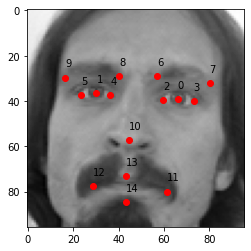

In [12]:
plot_keypoints(sample_img, sample_point)

在我們應用人臉關鍵點時，不管資料集文件沒有寫清楚，都可以通過把 index 畫出來的方式來理解關鍵點的順序。

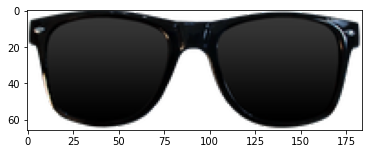

In [13]:
sunglasses = cv2.imread('sunglasses.png', cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED 表示要讀取圖像透明度的 channel
plt.imshow(sunglasses)

接下來我們利用預測到的人臉關鍵點信息，把這個太陽眼鏡放到 sample_img 上

**Note**: 這個太陽眼鏡的圖片必須是透明背景的 .png 哦，有興趣的同學也可以拿非透明背景的圖片來試看有什麼分別...

In [14]:
landmarks = model.predict(sample_img.reshape(-1, 96, 96, 1)) # 預測人臉關鍵點
landmarks = (landmarks + 0.5) * 96 # 將預測的人臉關鍵點的數值範圍由 -0.5 ~ 0.5 轉回 0 ~ 96
key_pts = landmarks.reshape(-1, 2)

face_img = cv2.cvtColor((sample_img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR) # 將灰階圖像轉為 BGR

# 以下示範如何用檢測到的關鍵點去定義要增加太陽眼鏡濾鏡的坐標，
# 其中使用的 key_pts index 就是由 plot_keypoints 所畫出來的 index 觀察而來
sunglass_top_x = int(key_pts[9, 0]) # 在這裡選右眉毛的最外側 (也就是第 9 index) 做太陽眼鏡的最左邊
sunglass_w = int(abs(key_pts[9, 0] - key_pts[7, 0])) # 在這裡選右眉毛最外側到左眉毛最外側 (也就是第 7、9 index) 做為太陽眼鏡的寬
sunglass_top_y = int((key_pts[9, 1] + key_pts[5, 1]) / 2) # y 和 h 也是類似的道理了
sunglass_h = int(abs(key_pts[8, 1] - key_pts[10, 1]) / 2)

new_sunglasses =  cv2.resize(sunglasses, (sunglass_w, sunglass_h), interpolation = cv2.INTER_CUBIC)

# roi 為要覆蓋太陽眼鏡的 BGR 人臉範圍
roi = face_img[sunglass_top_y:sunglass_top_y+sunglass_h, sunglass_top_x:sunglass_top_x+sunglass_w]

# 找出非透明的 pixel
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# 把 roi 中每個 channel 非透明的地方替換為太陽眼鏡的 pixel
for i in range(3):
    roi[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]

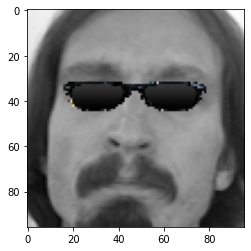

In [15]:
plt.imshow(face_img)

如此就完成一個簡單的太陽眼鏡人臉濾鏡啦！

實際應用中，人臉關鍵點檢測只是其實一個環節，要做到應用級別，至少還需要一個人臉檢測模型

而人臉相關的應用算是相對比較成熟的領域，所以可以找到很多研究和開源代碼，本課程有推薦一些項目，有興趣的同學可以自行參考～